<a href="https://colab.research.google.com/github/nikhilsharma110/DSML_Portfolio/blob/main/taxi_fare_guru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the required libraries

In [ ]:
import numpy as np #
import pandas as pd #
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score

## Load the training and test datasets

In [ ]:
df = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sample = pd.read_csv("/content/sample.csv")

### Check first 5 rows of data

In [ ]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


## Shape of training and testing data

In [ ]:
df.shape, test.shape

((175000, 17), (50000, 16))

Training data has 175000 rows and 17 columns. total_amount is the target variable.

## Basic info like Datatypes, Non-null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amount           175000 non-nu

Numerical type columns: 'VendorID','passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee'
       
       
Object type columns 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag', 'payment_type',

## Null Values in training and test data

In [ ]:
null_counts = pd.concat([df.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train Data', 'Test Data'])
print(null_counts)

                       Train Data  Test Data
VendorID                        0        0.0
tpep_pickup_datetime            0        0.0
tpep_dropoff_datetime           0        0.0
passenger_count              6077     1779.0
trip_distance                   0        0.0
RatecodeID                   6077     1779.0
store_and_fwd_flag           6077     1779.0
PULocationID                    0        0.0
DOLocationID                    0        0.0
payment_type                    0        0.0
extra                           0        0.0
tip_amount                      0        0.0
tolls_amount                    0        0.0
improvement_surcharge           0        0.0
total_amount                    0        NaN
congestion_surcharge         6077     1779.0
Airport_fee                  6077     1779.0


There are missing values in passenger_count, RatecodeID, store_and_fwd_flag, congestion_surcharge, Airport_fee

## Convert 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' to datetime

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])
test['tpep_dropoff_datetime'] = pd.to_datetime(test['tpep_dropoff_datetime'])

## Feature Engineering: Create new features 'trip_duration'

In [ ]:
# Calculate time difference
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

test['trip_duration'] = (test['tpep_dropoff_datetime'] - test['tpep_pickup_datetime']).dt.total_seconds() / 60

### Check if the operation was successful

In [ ]:
df[['tpep_dropoff_datetime', 'tpep_pickup_datetime','trip_duration']].head()

,tpep_dropoff_datetime,tpep_pickup_datetime,trip_duration
0,2023-06-28 16:34:45,2023-06-28 17:20:21,-45.600000
1,2023-06-29 22:01:35,2023-06-29 23:05:01,-63.433333
2,2023-06-30 11:13:10,2023-06-30 10:19:31,53.650000
3,2023-06-29 14:20:01,2023-06-29 13:23:09,56.866667
4,2023-06-29 22:22:22,2023-06-29 22:03:32,18.833333


A new column 'trip_duration' has been created

## Drop the original datetime columns

In [ ]:
df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)

test.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)

In [ ]:
df.shape, test.shape

((175000, 16), (50000, 15))

1 new columns is created and 2 columns are dropped

## Summary of numerical features

In [ ]:
summary = df.describe()
summary

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_duration
count,175000.000000,168923.000000,175000.000000,168923.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,168923.000000,168923.000000,175000.000000
mean,0.728377,1.357678,5.145930,1.518307,132.710349,132.701429,1.932143,6.127497,0.646816,0.979689,29.633901,2.246971,0.158825,17.893002
std,0.445606,0.891283,394.971052,6.514678,76.148799,76.192493,1.948497,4.610834,2.328274,0.198775,25.425206,0.819216,0.511968,62.263379
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000079,-29.300000,-1.000000,-576.750000,-2.500000,-1.750000,-118.900000
25%,0.000000,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473321,0.000000,1.000000,16.300000,2.500000,0.000000,-19.516667
50%,1.000000,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286217,0.000000,1.000000,21.450000,2.500000,0.000000,16.466667
75%,1.000000,1.000000,3.610000,1.000000,199.000000,199.000000,2.500000,7.502746,0.000000,1.000000,31.800000,2.500000,0.000000,53.166667
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,484.876151,80.000000,1.000000,587.250000,2.500000,1.750000,1537.150000


Average trip_duration is around 18 mins, average trip_distance is 5 and average total_amount is around 29.

Max trip_duration is around 1537 mins, average trip_distance is 135182 and average total_amount is around 587.


## EDA of numerical and categorical features

### I created some functions

In [ ]:
# histplot
def hist_plot(df, var):
    plt.figure(figsize=(8, 3))
    sns.histplot(data=df, x=df[var], kde = True, bins = 100)
    plt.title('Histgram')
    plt.show()

# Boxplot
def box_plot(df, var):
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=df[var])
    plt.title('Box Plot')
    plt.show()

# Countplot
def count_plot(df, var):
    plt.figure(figsize=(8, 3))
    sns.countplot(x=var, data=df)
    plt.title('Count Plot')
    plt.show()


# summary of numerical data
def eda_summary(df, var):
    print("Variable:", var)
    print("Datatype:", df[var].dtypes)
    print("\n_____________________________")

    # Summary of the count, unique values, top values, and frequency of the most common values
    var_summary = df[var].describe()
    print("\nSummary:\n", var_summary)
    print("\n_____________________________")

    # Outliers
    q1 = summary.loc['25%',var]
    q3 = summary.loc['75%',var]
    IQR = q3 - q1
    outlier = df[(df[var] < q1-1.5*IQR) | (df[var] > q3+1.5*IQR)]
    print("range: (max - min): ", max(df[var]) - min(df[var]))
    print("q1 (25th percentile): ", q1)
    print("q3: (75th percentile): ", q3)
    print("IQR (q3-q1): ", IQR)
    print("1.5*IQR: ", 1.5*IQR)
    print("q1-1.5*IQR: ", q1-1.5*IQR)
    print("values below q1-1.5*IQR: ", len(df[(df[var] < q1-1.5*IQR)]))
    print("q3+1.5*IQR: ", q3+1.5*IQR)
    print("values above q3+1.5*IQR: ", len(df[(df[var] > q3+1.5*IQR)]))
    print("Outliers count: ", len(outlier))
    print("Outliers are: ", round(100*(len(outlier)/len(df[var])),2), "% of the total count.")
    print("\n_____________________________")

    print("Count of Unique values: ", len(df[var].unique()))
    print("Unique values are: ", round(100*(len(df[var].unique())/len(df[var])),2), "% of total values.")
    print("Value Counts: ", df[var].value_counts())
    print("\n____________________________")


# summary of categorical data
def eda_summary2(df, var):
    print("Variable:", var)
    print("Datatype:", df[var].dtypes)
    print("\n____________________________")

    print("Count of Unique values: ", len(df[var].unique()))
    print("Unique values are: ", round(100*(len(df[var].unique())/len(df[var])),2), "% of total values.")
    print("Value Counts: ", df[var].value_counts())
    print("\n____________________________")


# Empirical Cumulative Distribution Function (ECDF) diagram.
def ecdf(df, var):
    # Sort the values in the variable column of the dataframe
    x = np.sort(df[var])
    # Get the number of data points
    n = len(x)
    # Generate y-values for every data point, which are evenly spaced by 1/n
    y = np.arange(1, n + 1, 1) / n
    # Create a new figure with specified size
    plt.figure(figsize=(8, 3))
    # Plot the ECDF diagram
    plt.plot(x, y, '.')
    # Set the title of the plot
    plt.title('ECDF diagram')
    # Display the plot
    plt.show()


### Analysis of 'total_amount'

In [ ]:
var = 'total_amount'
eda_summary(df, var)

Variable: total_amount
Datatype: float64

_____________________________

Summary:
 count    175000.000000
mean         29.633901
std          25.425206
min        -576.750000
25%          16.300000
50%          21.450000
75%          31.800000
max         587.250000
Name: total_amount, dtype: float64

_____________________________
range: (max - min):  1164.0
q1 (25th percentile):  16.3
q3: (75th percentile):  31.8
IQR (q3-q1):  15.5
1.5*IQR:  23.25
q1-1.5*IQR:  -6.949999999999999
values below q1-1.5*IQR:  1659
q3+1.5*IQR:  55.05
values above q3+1.5*IQR:  21820
Outliers count:  23479
Outliers are:  13.42 % of the total count.

_____________________________
Count of Unique values:  8164
Unique values are:  4.67 % of total values.
Value Counts:  total_amount
16.80     1787
12.60     1648
18.00     1515
21.00     1490
19.80     1260
          ... 
23.64        1
130.65       1
40.46        1
79.97        1
57.43        1
Name: count, Length: 8164, dtype: int64

____________________________

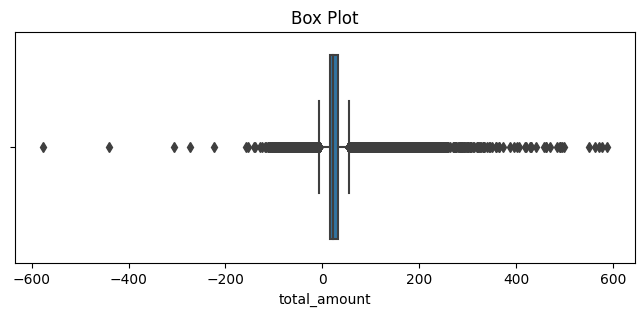

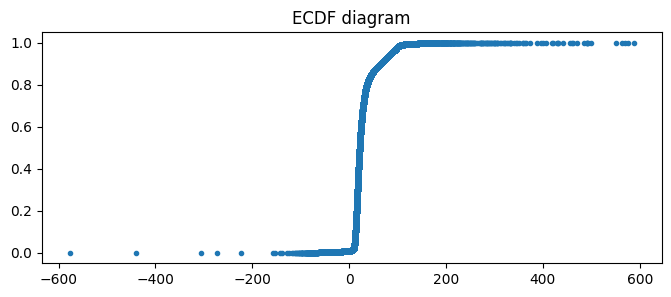

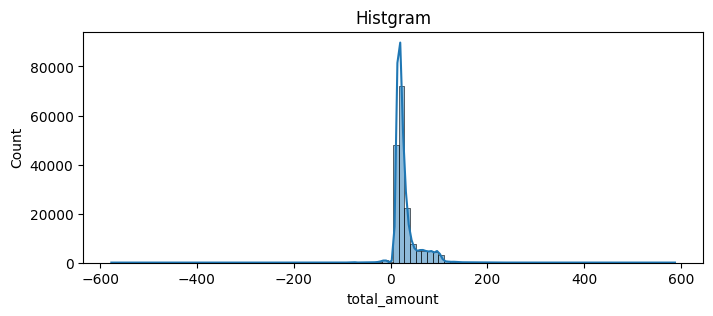

In [ ]:
box_plot(df,var)
ecdf(df, var)
hist_plot(df,var)

The data is spread between -576.75 and 587.25

### Analysis of 'trip_distance'

Variable: trip_distance
Datatype: float64

_____________________________

Summary:
 count    175000.000000
mean          5.145930
std         394.971052
min           0.000000
25%           1.080000
50%           1.840000
75%           3.610000
max      135182.060000
Name: trip_distance, dtype: float64

_____________________________
range: (max - min):  135182.06
q1 (25th percentile):  1.08
q3: (75th percentile):  3.61
IQR (q3-q1):  2.53
1.5*IQR:  3.795
q1-1.5*IQR:  -2.715
values below q1-1.5*IQR:  0
q3+1.5*IQR:  7.404999999999999
values above q3+1.5*IQR:  24133
Outliers count:  24133
Outliers are:  13.79 % of the total count.

_____________________________
Count of Unique values:  2929
Unique values are:  1.67 % of total values.
Value Counts:  trip_distance
0.00     2632
1.00     2431
0.90     2383
1.20     2363
1.10     2297
         ... 
31.42       1
26.80       1
27.53       1
13.29       1
15.17       1
Name: count, Length: 2929, dtype: int64

____________________________


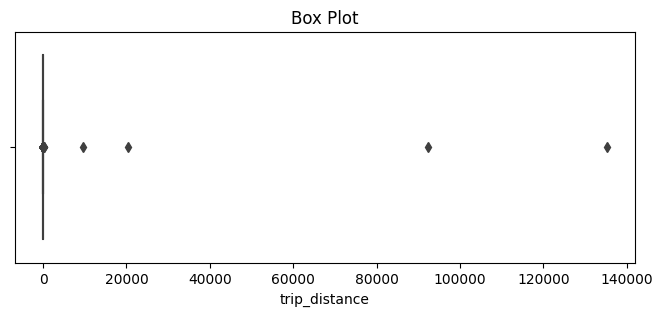

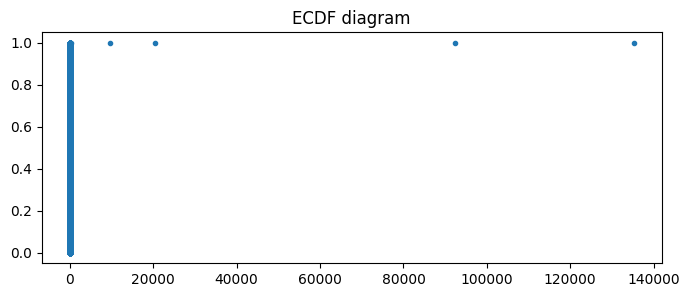

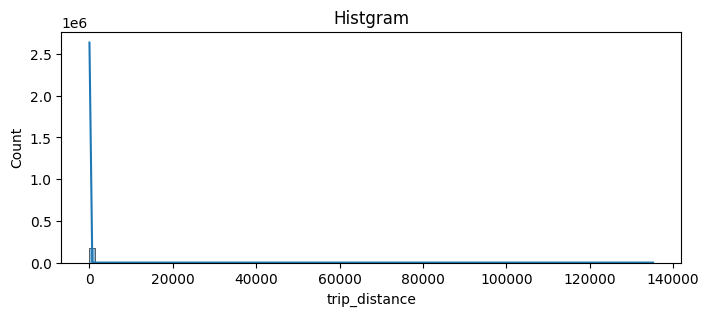

In [ ]:
var = 'trip_distance'
eda_summary(df, var)
box_plot(df,var)
ecdf(df,var)
hist_plot(df,var)

Effect of Outliers is clearly visible in the above visualizations

In [ ]:
df[df["trip_distance"] > 200]

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_duration
55147,1,1.0,9673.69,1.0,N,107,228,Credit Card,0.0,6.042202,0.0,1.0,9.60,0.0,0.0,-0.516667
70458,1,NaN,20314.00,NaN,NaN,249,84,Wallet,0.0,9.657420,0.0,1.0,42.56,NaN,NaN,72.816667
85525,1,NaN,135182.06,NaN,NaN,133,80,Wallet,0.0,5.948871,0.0,1.0,27.92,NaN,NaN,-50.150000
107988,1,NaN,92292.43,NaN,NaN,55,71,Wallet,0.0,4.262185,0.0,1.0,18.00,NaN,NaN,85.016667


## Outliers in trip_distance: treatment

In [ ]:
def rmv_otl(data):
    data.loc[data['trip_distance'] > 200, 'trip_distance'] = np.nan
    return data

df = rmv_otl(df)
test = rmv_otl(test)

Values above 200 are changed to np.nan, which will be imputed later

### Check if the above operation was successful

In [ ]:
df.iloc[[0, 55147, 70458, 85525, 107988]]

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_duration
0,1,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0,-45.600000
55147,1,1.0,NaN,1.0,N,107,228,Credit Card,0.0,6.042202,0.0,1.0,9.60,0.0,0.0,-0.516667
70458,1,NaN,NaN,NaN,NaN,249,84,Wallet,0.0,9.657420,0.0,1.0,42.56,NaN,NaN,72.816667
85525,1,NaN,NaN,NaN,NaN,133,80,Wallet,0.0,5.948871,0.0,1.0,27.92,NaN,NaN,-50.150000
107988,1,NaN,NaN,NaN,NaN,55,71,Wallet,0.0,4.262185,0.0,1.0,18.00,NaN,NaN,85.016667


### boxplot and ecdf diagram after removing outliers

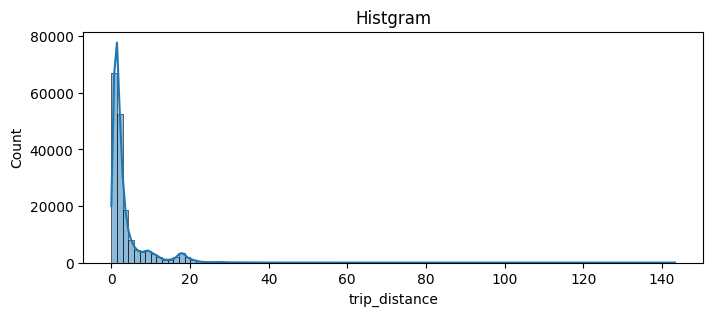

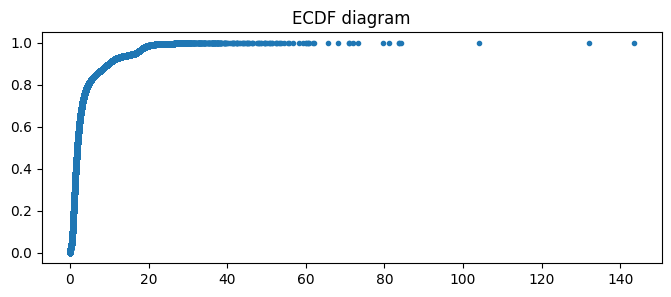

In [ ]:
hist_plot(df, 'trip_distance' )
ecdf(df, var)

### Analysis of 'extra'

Variable: extra
Datatype: float64

____________________________
Count of Unique values:  28
Unique values are:  0.02 % of total values.
Value Counts:  extra
 0.00     51247
 2.50     50180
 1.00     35614
 5.00     17280
 3.50     11839
 7.50      2351
 6.00      1774
 4.25       871
 9.25       812
-1.00       514
-2.50       472
 1.75       413
 2.75       375
 6.75       284
 11.75      258
 10.25      231
 7.75       199
 10.00       96
-5.00        76
 8.50        56
-7.50        22
-6.00        21
 5.25         8
 0.75         2
 3.25         2
 0.25         1
 0.11         1
 1.50         1
Name: count, dtype: int64

____________________________


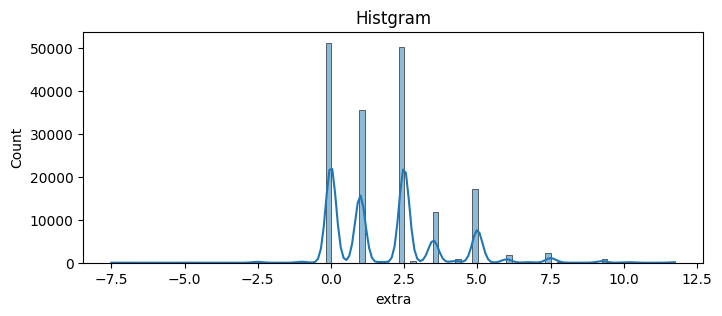

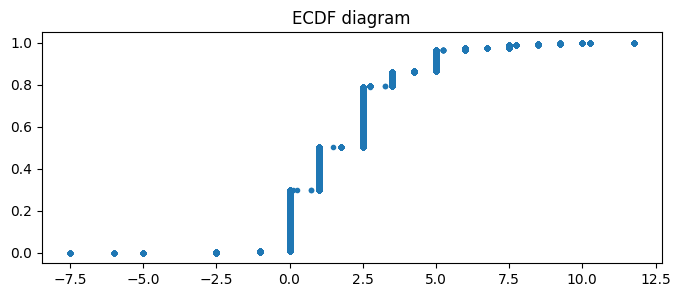

In [ ]:
var = 'extra'
eda_summary2(df,var)
hist_plot(df, var)
ecdf(df, var)

### Analysis of 'PULocationID'

Variable: PULocationID
Datatype: int64

____________________________
Count of Unique values:  264
Unique values are:  0.15 % of total values.
Value Counts:  PULocationID
264    730
85     725
43     719
162    718
97     717
      ... 
254    613
94     613
153    611
179    606
252    606
Name: count, Length: 264, dtype: int64

____________________________


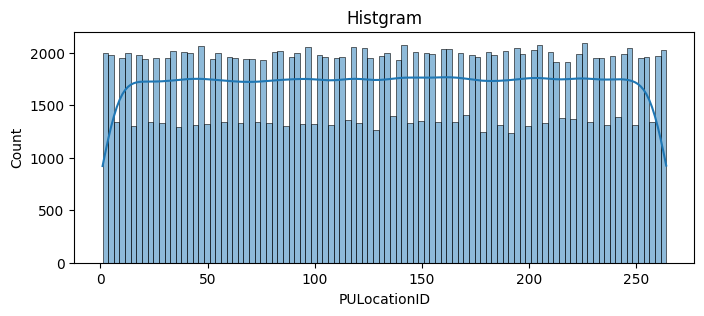

In [ ]:
var = 'PULocationID'
eda_summary2(df,var)
hist_plot(df, var)

### Analysis of 'DULocationID'

Variable: DOLocationID
Datatype: int64

____________________________
Count of Unique values:  264
Unique values are:  0.15 % of total values.
Value Counts:  DOLocationID
263    759
127    736
37     729
115    726
254    721
      ... 
9      611
140    610
195    607
187    606
183    605
Name: count, Length: 264, dtype: int64

____________________________


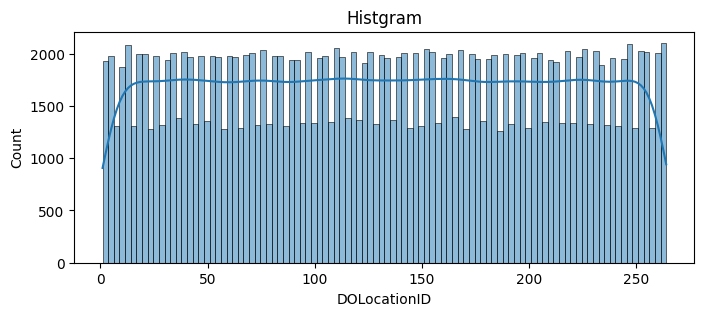

In [ ]:
var = 'DOLocationID'
eda_summary2(df, var)
hist_plot(df, var)

### Analysis of 'VendorID'

Variable: VendorID
Datatype: int64

____________________________
Count of Unique values:  3
Unique values are:  0.0 % of total values.
Value Counts:  VendorID
1    127340
0     47597
2        63
Name: count, dtype: int64

____________________________


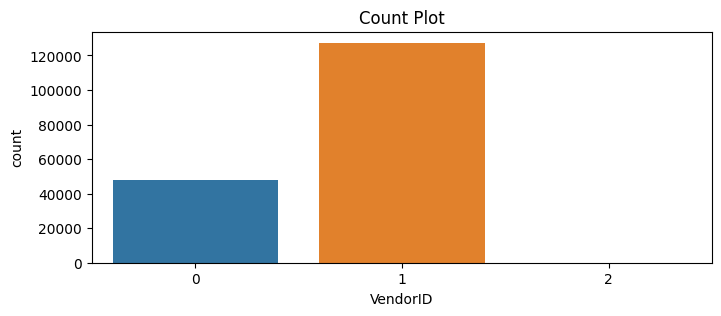

In [ ]:
var = 'VendorID'
eda_summary2(df, var)
count_plot(df, var)

VendorID 2 has very few values

### Analysis of 'congestion_surcharge'

Variable: congestion_surcharge
Datatype: float64

____________________________
Count of Unique values:  4
Unique values are:  0.0 % of total values.
Value Counts:  congestion_surcharge
 2.5    153212
 0.0     14325
-2.5      1386
Name: count, dtype: int64

____________________________


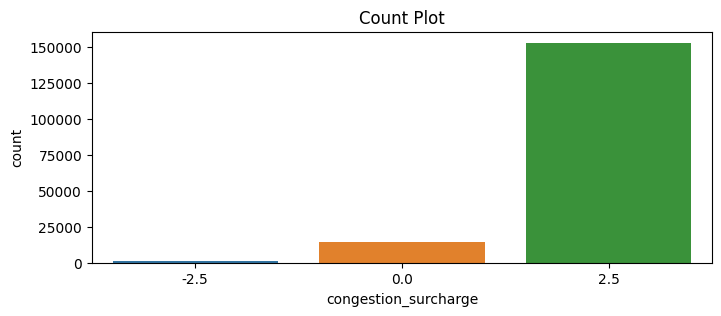

In [ ]:
var = 'congestion_surcharge'
eda_summary2(df, var)
count_plot(df, var)

2.5 is the most common value for congestion_surcharge

### Analysis of 'improvement_surcharge'

Variable: improvement_surcharge
Datatype: float64

____________________________
Count of Unique values:  4
Unique values are:  0.0 % of total values.
Value Counts:  improvement_surcharge
 1.0    173145
-1.0      1725
 0.3        85
 0.0        45
Name: count, dtype: int64

____________________________


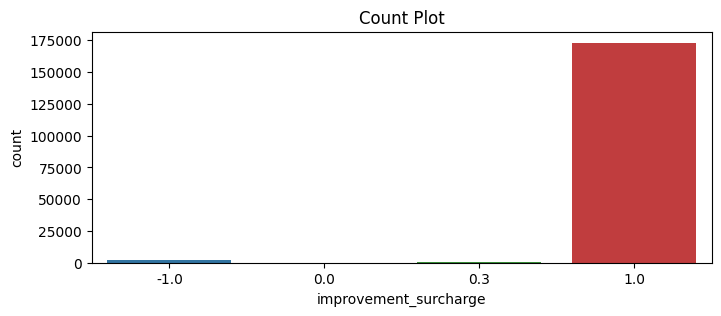

In [ ]:
var = 'improvement_surcharge'
eda_summary2(df, var)
count_plot(df, var)

1.0 is the most common value for improvement_surcharge

### Analysis of 'Airport_fee'

Variable: Airport_fee
Datatype: float64

____________________________
Count of Unique values:  4
Unique values are:  0.0 % of total values.
Value Counts:  Airport_fee
 0.00    153074
 1.75     15590
-1.75       259
Name: count, dtype: int64

____________________________


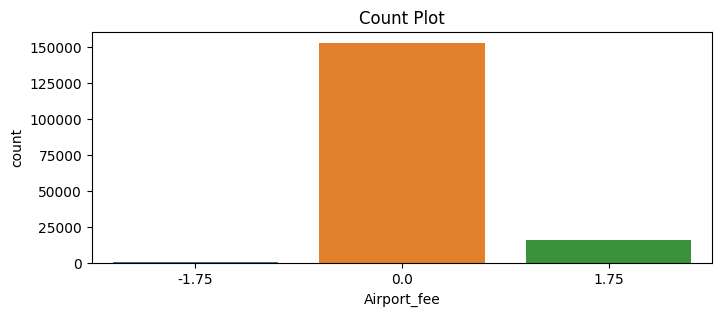

In [ ]:
var = 'Airport_fee'
eda_summary2(df, var)
count_plot(df, var)

0.0 is the most common Airport_fee

### Analysis of passenger_count

Variable: passenger_count
Datatype: float64

____________________________
Count of Unique values:  10
Unique values are:  0.01 % of total values.
Value Counts:  passenger_count
1.0    128534
2.0     24316
3.0      6018
4.0      3668
0.0      2818
5.0      1970
6.0      1596
8.0         2
9.0         1
Name: count, dtype: int64

____________________________


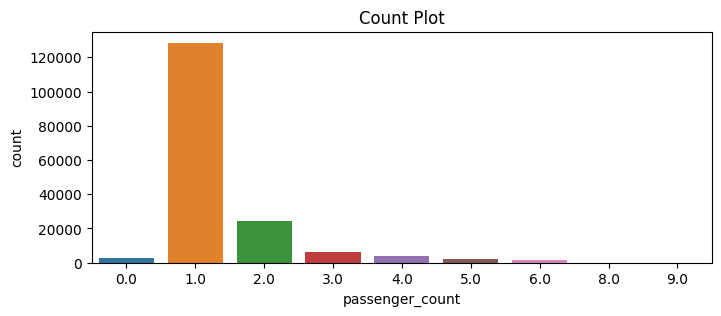

In [ ]:
var = 'passenger_count'
eda_summary2(df, var)
count_plot(df, var)

1 is the most popular passenger count and 8,9 are the least popular

### Analysis of 'RatecodeID'

Variable: RatecodeID
Datatype: float64

____________________________
Count of Unique values:  7
Unique values are:  0.0 % of total values.
Value Counts:  RatecodeID
1.0     158652
2.0       7314
5.0       1036
99.0       748
3.0        727
4.0        446
Name: count, dtype: int64

____________________________


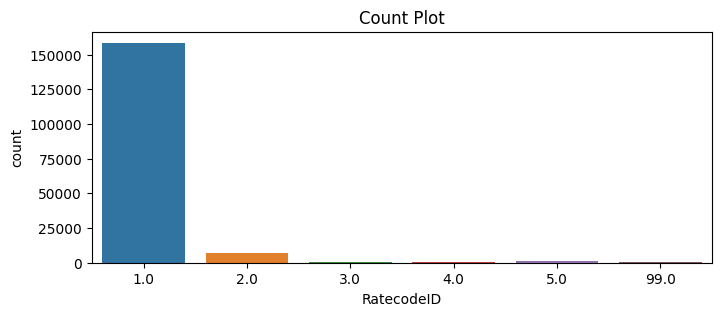

In [ ]:
var = 'RatecodeID'
eda_summary2(df, var)
count_plot(df, var)

1 is the most popular ratecode id

### Analysis of 'store_and_fwd_flag'

Variable: store_and_fwd_flag
Datatype: object

____________________________
Count of Unique values:  3
Unique values are:  0.0 % of total values.
Value Counts:  store_and_fwd_flag
N    167729
Y      1194
Name: count, dtype: int64

____________________________


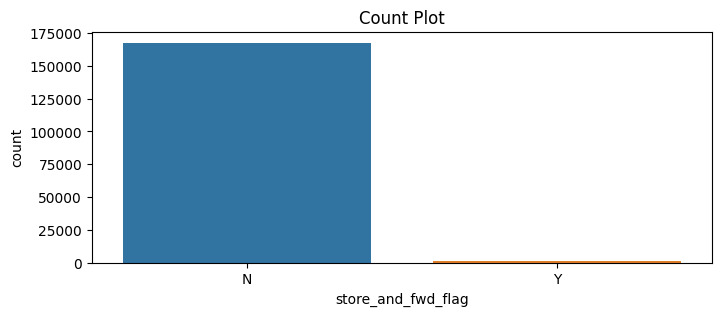

In [ ]:
var = 'store_and_fwd_flag'
eda_summary2(df, var)
count_plot(df, var)

There are very few Y in comarison to the N

### Analysis of 'payment_type'

Variable: payment_type
Datatype: object

____________________________
Count of Unique values:  5
Unique values are:  0.0 % of total values.
Value Counts:  payment_type
Credit Card    135257
Cash            30141
Wallet           6077
unknown          2333
UPI              1192
Name: count, dtype: int64

____________________________


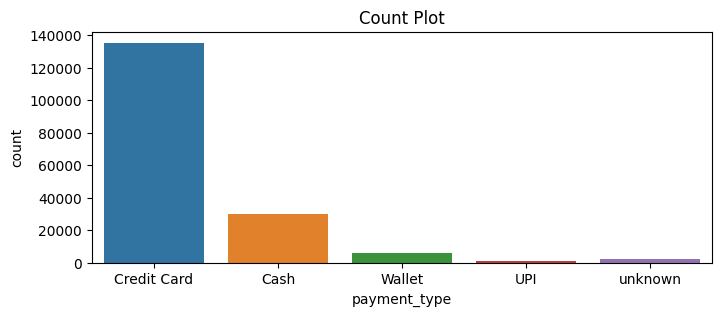

In [ ]:
var = 'payment_type'
eda_summary2(df, var)
count_plot(df, var)

### Analysis of 'trip_duration'

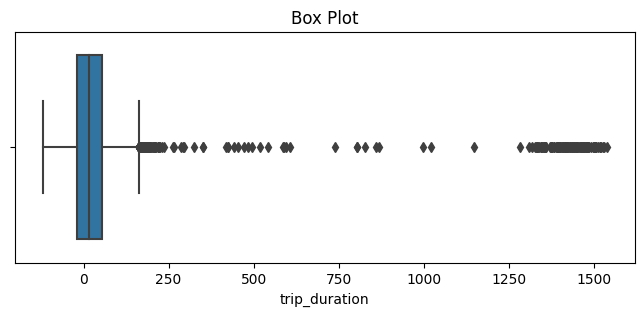

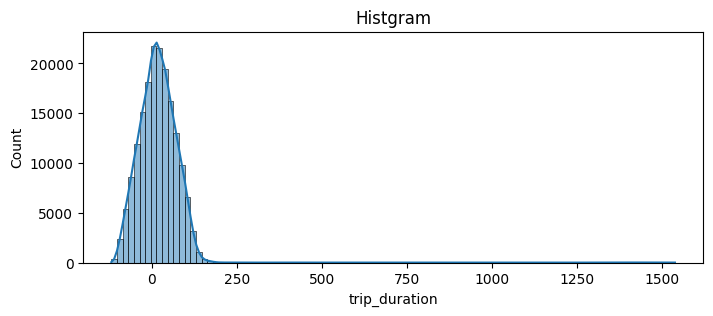

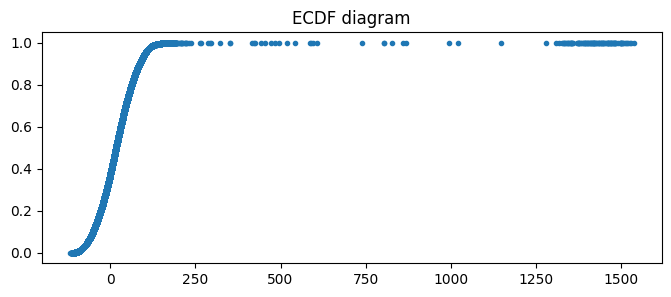

In [ ]:
var = 'trip_duration'
df[var].describe()
box_plot(df,var)
hist_plot(df,var)
ecdf(df,var)

In [ ]:
df.loc[df["trip_duration"]>300,["total_amount", 'tip_amount', 'trip_distance', 'trip_duration']].head()

,total_amount,tip_amount,trip_distance,trip_duration
1270,15.4,1.799322,1.33,1436.950000
1673,13.7,1.213517,0.81,1525.383333
2413,29.4,5.705067,2.10,596.316667
2592,21.0,1.770390,2.72,1537.150000
3142,20.3,2.332104,2.75,1483.583333


Some very high values of trip_duration have very low trip_distance and total_amount, which is very unlikely

## Treat the outliers in trip_duration

In [ ]:
def rmv_otl2(data):
    data.loc[data['trip_duration'] > 500, 'trip_duration'] = np.nan
    return data

df = rmv_otl2(df)
test = rmv_otl2(test)

Values above 500 are changed to np.nan

### Check if the above operation was successful

In [ ]:
df.loc[[0,1270,1673,174529], ["total_amount", 'tip_amount', 'trip_distance', 'trip_duration']]

,total_amount,tip_amount,trip_distance,trip_duration
0,20.64,7.165589,2.14,-45.6
1270,15.40,1.799322,1.33,NaN
1673,13.70,1.213517,0.81,NaN
174529,26.20,0.241668,4.68,NaN


### boxplot and ecdf diagram after removing outliers

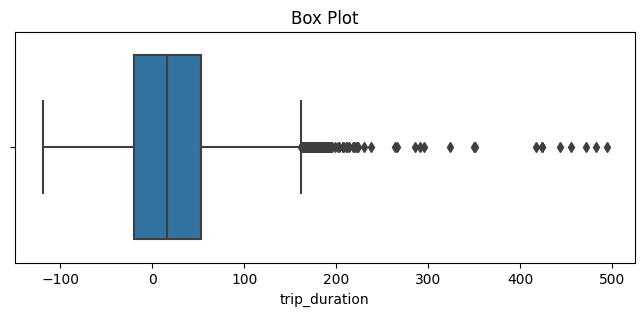

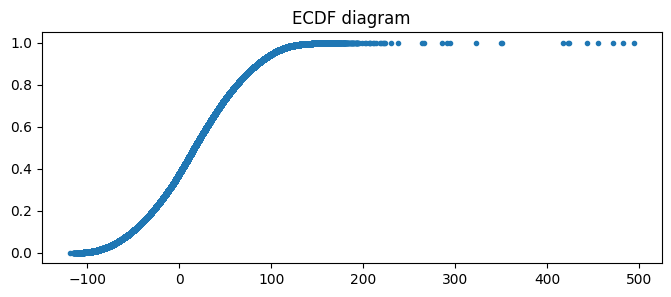

In [ ]:
box_plot(df,var)
ecdf(df,var)

## Bivariate analysis using scatter plot

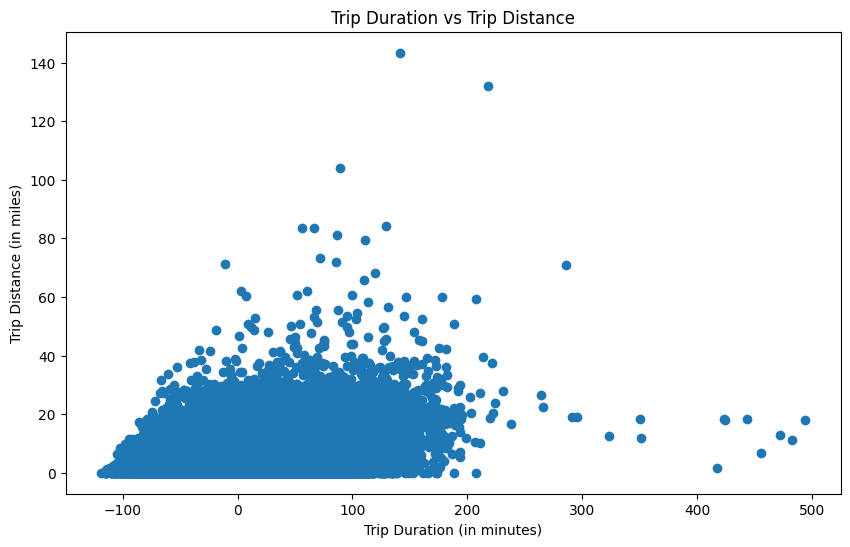

In [ ]:
plt.figure(figsize=(10,6))

plt.scatter(df['trip_duration'], df['trip_distance'])
plt.xlabel('Trip Duration (in minutes)')
plt.ylabel('Trip Distance (in miles)')
plt.title('Trip Duration vs Trip Distance')

plt.show()


It is expected that with the increase in trip_duration, trip_distance will also increase. Which can be seen in the
visualization.

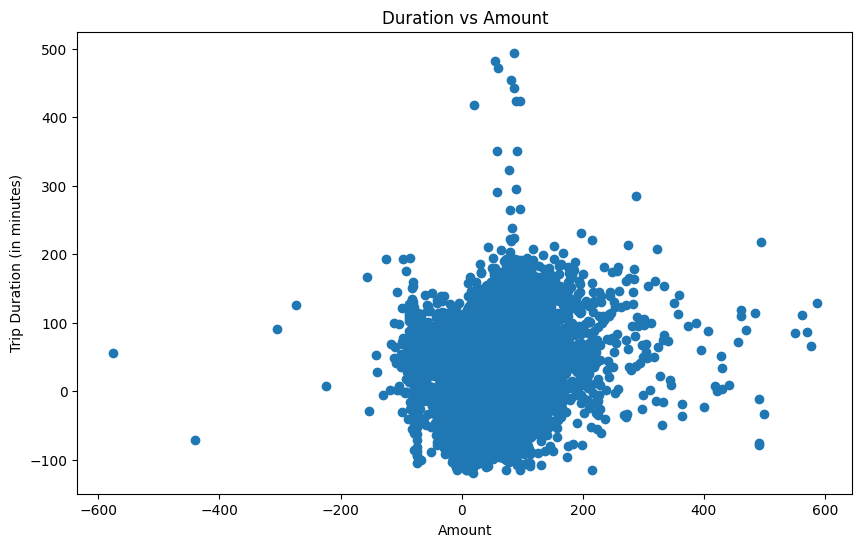

In [ ]:
#scatterplot
plt.figure(figsize=(10,6))

plt.scatter(df['total_amount'], df['trip_duration'])
plt.xlabel('Amount')
plt.ylabel('Trip Duration (in minutes)')
plt.title('Duration vs Amount')

plt.show()

It is expected that with the increase in the trip_duration the total_amount also increases. Which is somewhat visible in the
vizualisation.

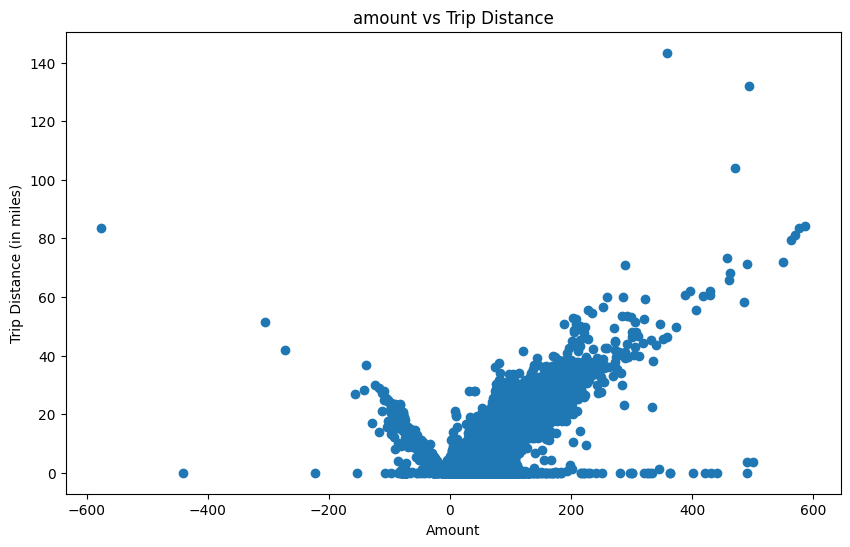

In [ ]:
#scatterplot
plt.figure(figsize=(10,6))

plt.scatter(df['total_amount'], df['trip_distance'])
plt.xlabel('Amount')
plt.ylabel('Trip Distance (in miles)')
plt.title('amount vs Trip Distance')

plt.show()

It is expected that with the increase in the trip_distance the total_amount also increases. Which is somewhat visible in the
vizualisation.

## Bivariate analysis using boxplot

<Axes: xlabel='VendorID', ylabel='total_amount'>

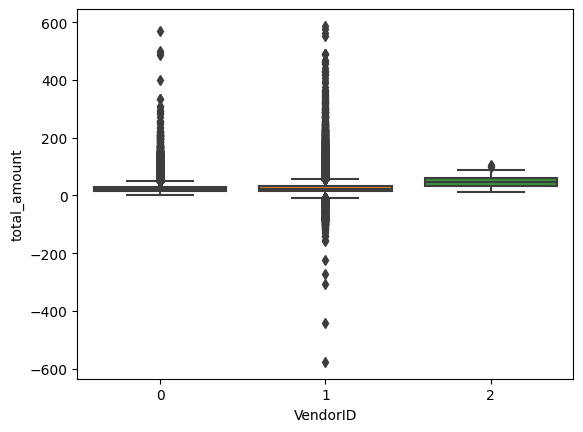

In [ ]:
sns.boxplot(x='VendorID',y='total_amount',data=df)

Median of different VendorID's look similar

<Axes: xlabel='passenger_count', ylabel='total_amount'>

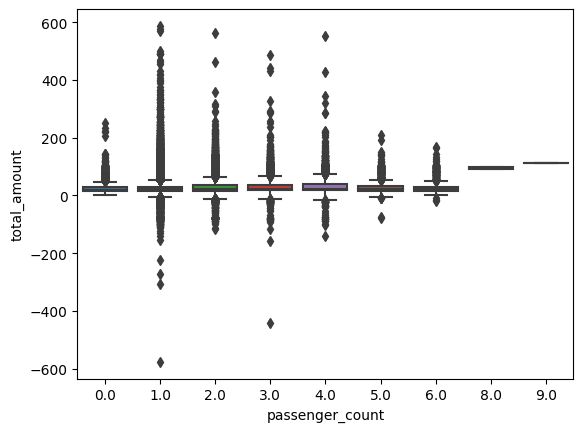

In [ ]:
sns.boxplot(x='passenger_count',y='total_amount',data=df)

Median value of passenger count 0-6 looks similar in the graph

<Axes: xlabel='payment_type', ylabel='total_amount'>

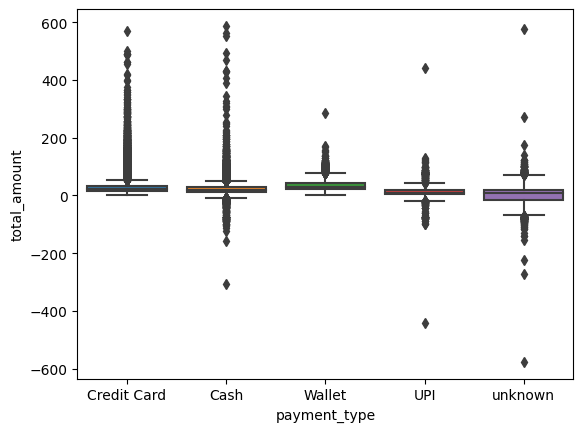

In [ ]:
sns.boxplot(x='payment_type',y='total_amount',data=df)

There is no significant difference in the median values of different payment methods

<Axes: xlabel='RatecodeID', ylabel='total_amount'>

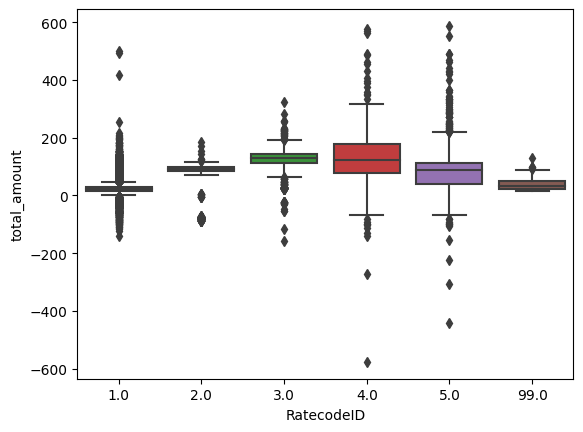

In [ ]:
sns.boxplot(x='RatecodeID',y='total_amount',data=df)

There is clear difference between the median values of different RatecodeID

### Correlation heatmap

<Axes: >

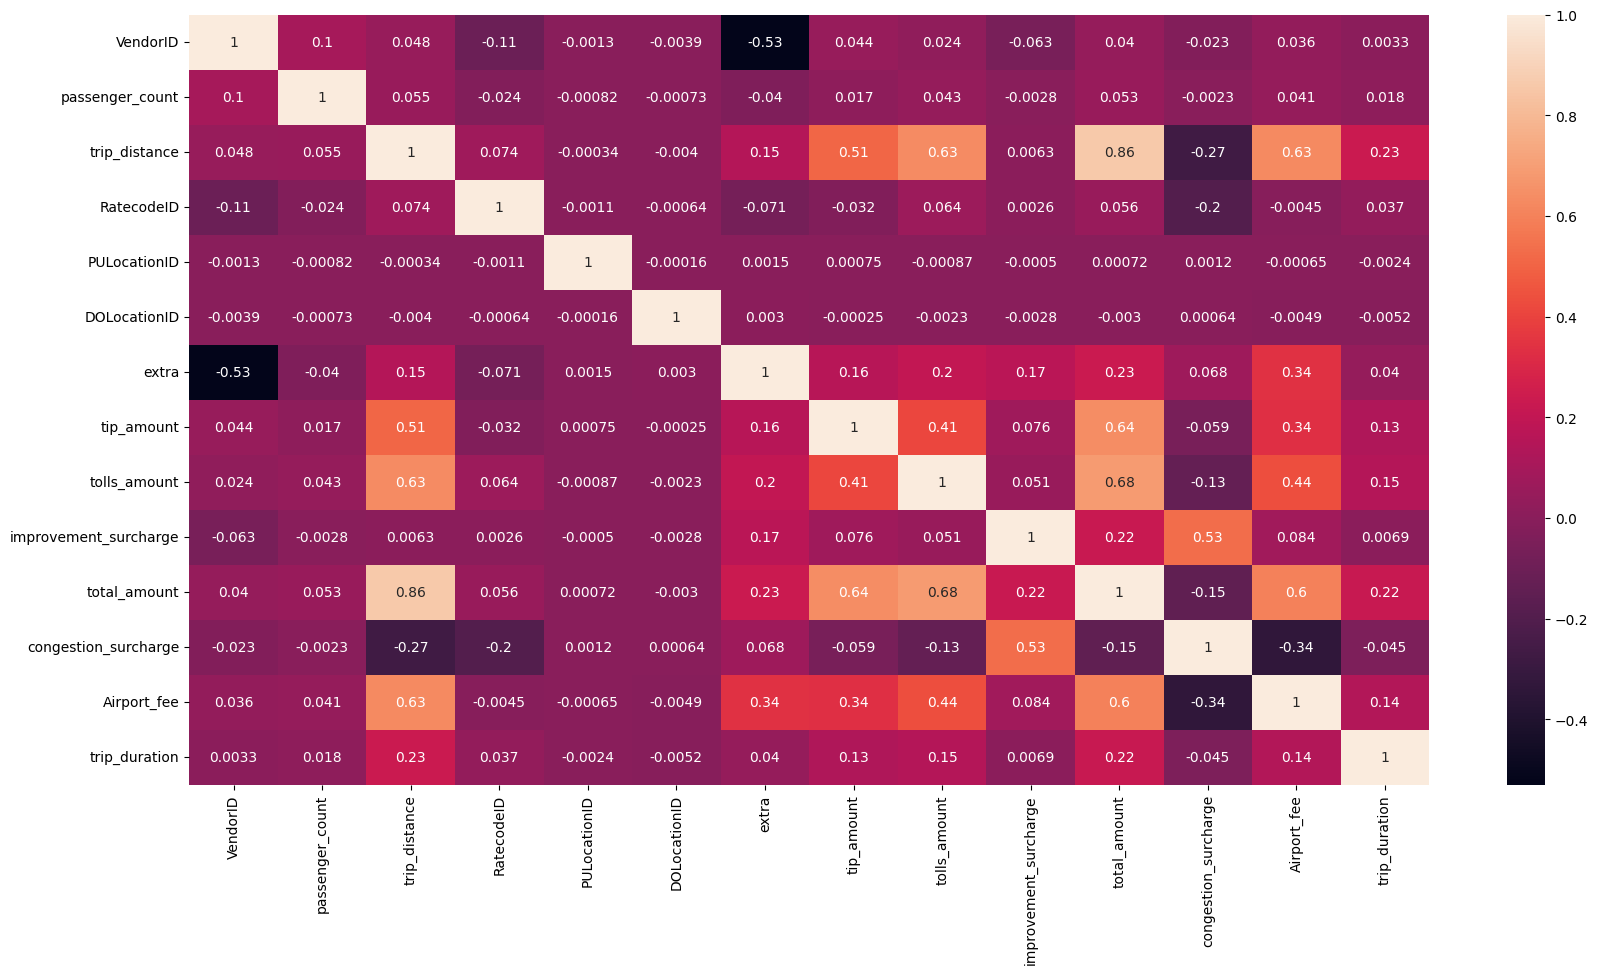

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(numeric_only=True), annot = True)

Very Dark and very light colors represents higher correlation. Clearly trip_distance, tip_amount, tolls_amount and Airport_fee has very strong correlation with total_amount.

## List of correlation values with the total_amount

In [ ]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix['total_amount'].sort_values(ascending=False)

total_amount             1.000000
trip_distance            0.859146
tolls_amount             0.684765
tip_amount               0.638658
Airport_fee              0.597829
extra                    0.234346
improvement_surcharge    0.224036
trip_duration            0.221252
RatecodeID               0.055527
passenger_count          0.053224
VendorID                 0.039695
PULocationID             0.000715
DOLocationID            -0.002954
congestion_surcharge    -0.147765
Name: total_amount, dtype: float64

POLocation and DOLocation shows very little correlation with the total_amount column

## Remove the features with low correlation

In [ ]:
df.drop(columns=["PULocationID", "DOLocationID"],axis = 1,  inplace = True)
test.drop(columns=["PULocationID", "DOLocationID"],axis = 1,  inplace = True)

### One more look at the null values present in the dataset

In [ ]:
df.isnull().sum()

VendorID                    0
passenger_count          6077
trip_distance               4
RatecodeID               6077
store_and_fwd_flag       6077
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
trip_duration             121
dtype: int64

## Split the dataset into training set (80%) and validation set (20%)

In [ ]:
X = df.drop('total_amount', axis=1)  # X is the features
y = df['total_amount']  # y is the target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Shape of the training and validation datasets after train_test_split

In [ ]:
X_train.shape, X_val.shape,y_train.shape, y_val.shape

((140000, 13), (35000, 13), (140000,), (35000,))

## Pipeline for imputation, encoding and scaling

In [ ]:
# funtion to do imputation and scaling of numerical features
def num_pipeline_transformer(data):

    numerics = ['float64', 'int64']

    num_attrs = data.select_dtypes(include=numerics)

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
        ])
    return num_attrs, num_pipeline

# funtion to do OneHotEncoding on categorical features
def pipeline_transformer(data):

    cat_attrs = ['store_and_fwd_flag', 'payment_type']

    num_attrs, num_pipeline = num_pipeline_transformer(data)

    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, list(num_attrs)),
        ("cat", OneHotEncoder(), cat_attrs),
        ])
    prepared_data = full_pipeline.fit_transform(data)
    return prepared_data

## Transform the data using pipeline

In [ ]:
X_train_prepared = pipeline_transformer(X_train)
X_val_prepared = pipeline_transformer(X_val)

In [ ]:
X_train_prepared.shape, X_val_prepared.shape

((140000, 19), (35000, 19))

The transformed data now has 19 features

## Model Building

## Base Model

In [ ]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train_prepared, y_train)

y_train_pred = baseline.predict(X_train_prepared)

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'Mean Squared Error (training): {mse}')
print(f'R2 Error (training): {r2}')

y_val_pred = baseline.predict(X_val_prepared)

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f'Mean Squared Error (val): {mse}')
print(f'R2 Error (val): {r2}')

# Cross validation score
cv_score = cross_val_score(baseline,X_train_prepared, y_train, cv=5, scoring='r2')
print("CV Score:", cv_score)

Mean Squared Error (training): 645.3523298264281
R2 Error (training): 0.0
Mean Squared Error (val): 650.7826094282631
R2 Error (val): -3.7584352301278656e-05
CV Score: [-1.67086835e-04 -1.66209467e-04 -1.61300342e-05 -1.15286963e-04
 -2.00763978e-04]


## Visualize the actual vs predicated values

In [ ]:
# functions to visualize the results of the model
def predvsact(y_train,y_train_pred,y_val, y_val_pred):
    # Plotting predicted vs actual for training data
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train, y_train, color='blue', label='Actual')
    plt.scatter(y_train, y_train_pred, color='red', label='Predicted')
    plt.legend(loc='upper left')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted - Training Data')
    plt.show()

    # Plotting predicted vs actual for validation data
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_val, color='blue', label='Actual')
    plt.scatter(y_val, y_val_pred, color='red', label='Predicted')
    plt.legend(loc='upper left')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted - Validation Data')
    plt.show()
def resvspred(y_train,y_train_pred,y_val, y_val_pred):
    # Calculate residuals
    residuals_train = y_train - y_train_pred
    residuals_val = y_val - y_val_pred

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train_pred, residuals_train, alpha=0.5, label='Train')
    plt.scatter(y_val_pred, residuals_val, alpha=0.5, label='Validation')
    plt.hlines(0, min(y_train_pred), max(y_train_pred), colors='r')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')
    plt.legend()
    plt.show()

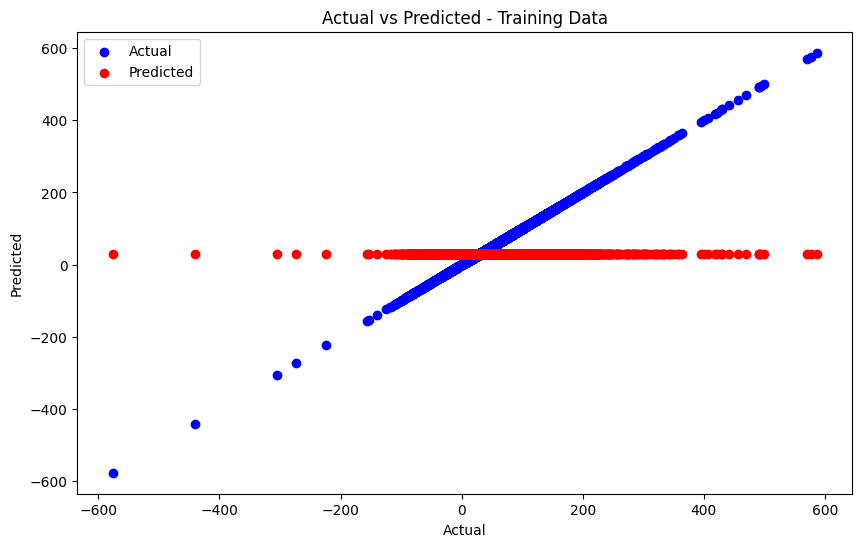

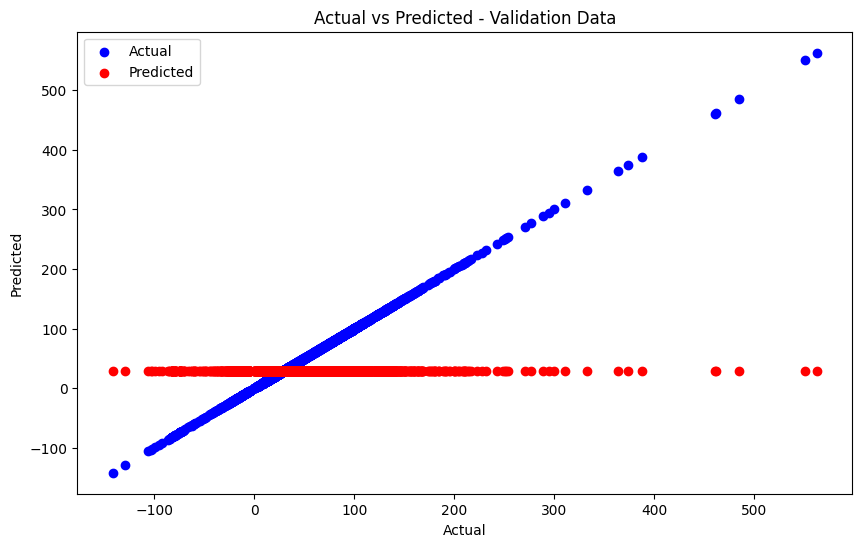

In [ ]:
predvsact(y_train,y_train_pred,y_val, y_val_pred)

Same value is predicted for every value

## Visualize the residuals vs predicted values

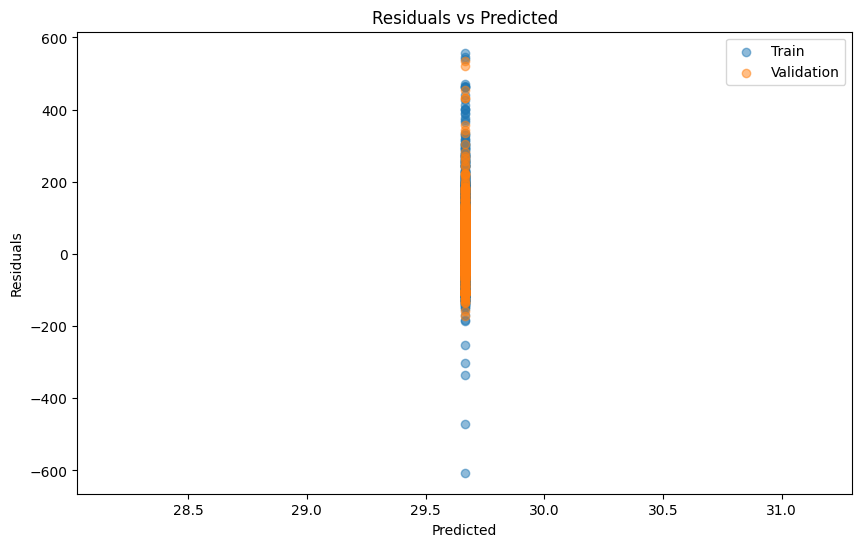

In [ ]:
resvspred(y_train,y_train_pred,y_val, y_val_pred)

Residuals are all over the place

## Simple Linear Regression Model

In [ ]:
lr = LinearRegression()
lr.fit(X_train_prepared, y_train)

y_train_pred = lr.predict(X_train_prepared)

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'Mean Squared Error (training): {mse}')
print(f'R2 Error (training): {r2}')

y_val_pred = lr.predict(X_val_prepared)

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f'Mean Squared Error (val): {mse}')
print(f'R2 Error(val): {r2}')

# Cross validation score
cv_score = cross_val_score(lr,X_train_prepared, y_train, cv=5, scoring='r2')
print("CV Score:", cv_score)

Mean Squared Error (training): 92.5120785939545
R2 Error (training): 0.8566487261015447
Mean Squared Error (val): 80.31991178537994
R2 Error(val): 0.8765748663323871
CV Score: [0.85250603 0.86307647 0.86453475 0.85541271 0.84631973]


## Visualize the predicted vs actual labels

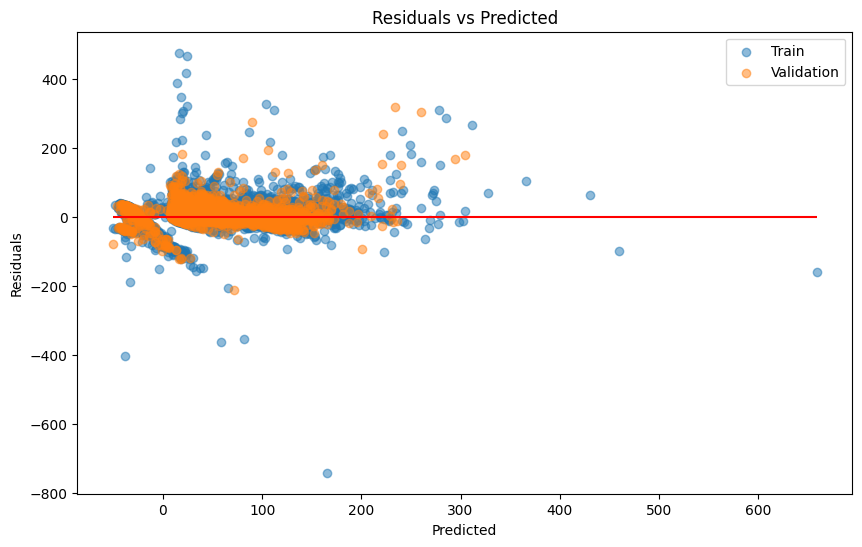

In [ ]:
resvspred(y_train,y_train_pred,y_val, y_val_pred)

Residuals are closer to 0

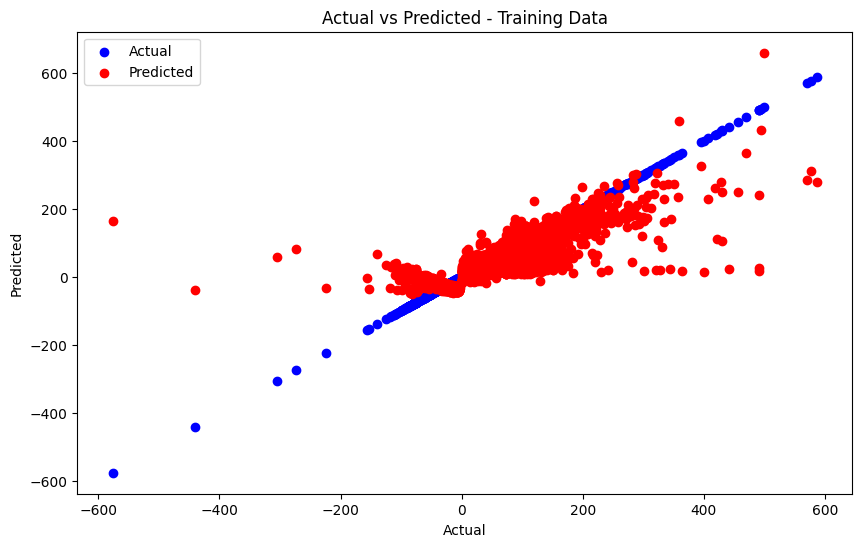

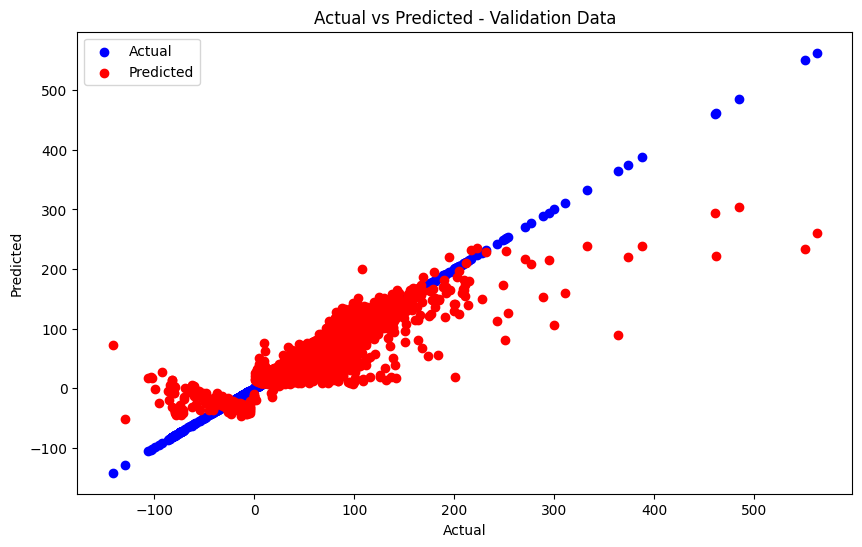

In [ ]:
predvsact(y_train,y_train_pred,y_val, y_val_pred)

Predicted and Actual values are much closer in this case

## Lasso regression with polynomial features and feature selection

In [ ]:
poly_model = Pipeline([('feature_selection', SelectKBest(score_func = f_regression, k = 9)),
                       ('polynomial_transform', PolynomialFeatures(degree=2)),
                       ('lasso', Lasso(random_state=11))])

poly_model.fit(X_train_prepared, y_train)

y_train_pred = poly_model.predict(X_train_prepared)

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'Mean Squared Error (training): {mse}')
print(f'R2 Error (training): {r2}')

y_val_pred = poly_model.predict(X_val_prepared)

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f'Mean Squared Error (val): {mse}')
print(f'R2 Error (val): {r2}')

# Cross validation score
cv_score = cross_val_score(poly_model,X_train_prepared, y_train, cv=5, scoring='r2')
print("CV Score:", cv_score)

Mean Squared Error (training): 79.3713357845507
R2 Error (training): 0.8770108480031393
Mean Squared Error (val): 72.15230747661819
R2 Error (val): 0.889125772217926
CV Score: [0.86671333 0.88092759 0.88233522 0.87029705 0.73546058]


MSE and R2 Scores are better than the previous model

In [ ]:
# Hyperparameter tuning

'''
# Define the pipeline
poly_model = Pipeline([
    ('feature_selection', SelectKBest(score_func = f_regression)),
    ('polynomial_transform', PolynomialFeatures()),
    ('lasso', Lasso(random_state=11))
])

# Define the parameter grid
param_grid = {
    'feature_selection__k': [5,6,7,8 9,10,11,12,15],  # number of features
    'polynomial_transform__degree': [1, 2, 3],  # degree of polynomial features
    'lasso__alpha': [0.1, 1.0, 5.0, 10.0]  # regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(poly_model, param_grid, cv=5, scoring='r2')

# Fit and tune model
grid_search.fit(X_train_prepared, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Evaluate the model
y_train_pred = grid_search.predict(X_train_prepared)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f'Mean Squared Error (training): {mse}')
print(f'R2 Error (training): {r2}')

y_val_pred = grid_search.predict(X_val_prepared)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f'Mean Squared Error (val): {mse}')
print(f'R2 Error (val): {r2}')
'''

"\n# Define the pipeline\npoly_model = Pipeline([\n    ('feature_selection', SelectKBest(score_func = f_regression)),\n    ('polynomial_transform', PolynomialFeatures()),\n    ('lasso', Lasso(random_state=11))\n])\n\n# Define the parameter grid\nparam_grid = {\n    'feature_selection__k': [5,6,7,8 9,10,11,12,15],  # number of features\n    'polynomial_transform__degree': [1, 2, 3],  # degree of polynomial features\n    'lasso__alpha': [0.1, 1.0, 5.0, 10.0]  # regularization strength\n}\n\n# Initialize GridSearchCV\ngrid_search = GridSearchCV(poly_model, param_grid, cv=5, scoring='r2')\n\n# Fit and tune model\ngrid_search.fit(X_train_prepared, y_train)\n\n# Get the best parameters\nbest_params = grid_search.best_params_\nprint(f'Best parameters: {best_params}')\n\n# Evaluate the model\ny_train_pred = grid_search.predict(X_train_prepared)\nmse = mean_squared_error(y_train, y_train_pred)\nr2 = r2_score(y_train, y_train_pred)\nprint(f'Mean Squared Error (training): {mse}')\nprint(f'R2 Erro

## Visualize Residuals vs Predicted

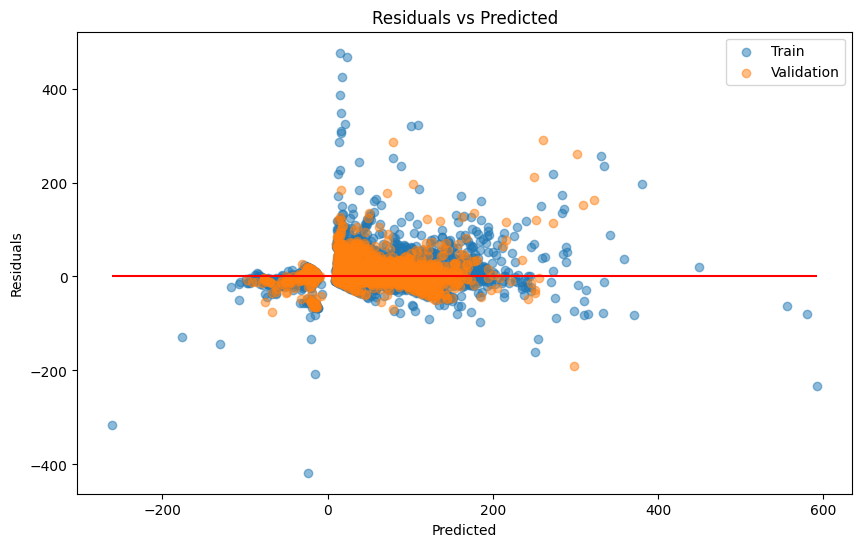

In [ ]:
resvspred(y_train,y_train_pred,y_val, y_val_pred)

## Visualize the predicted vs actual labels

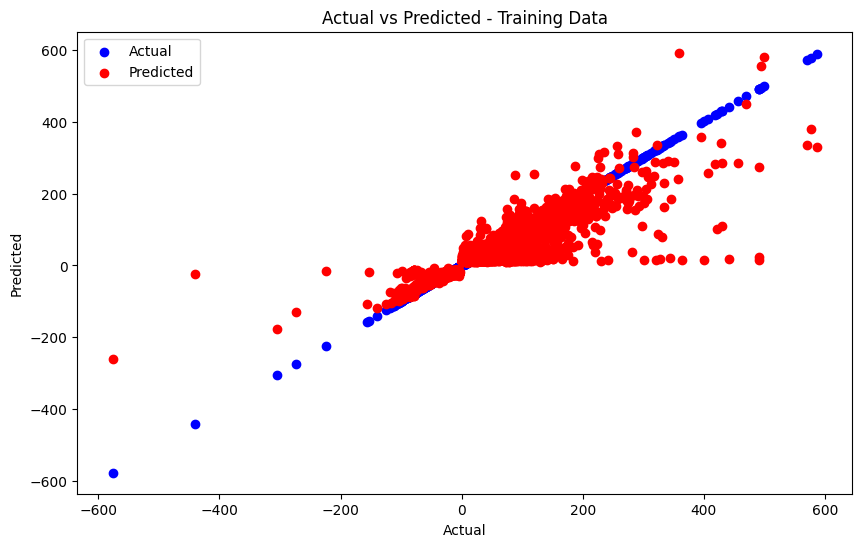

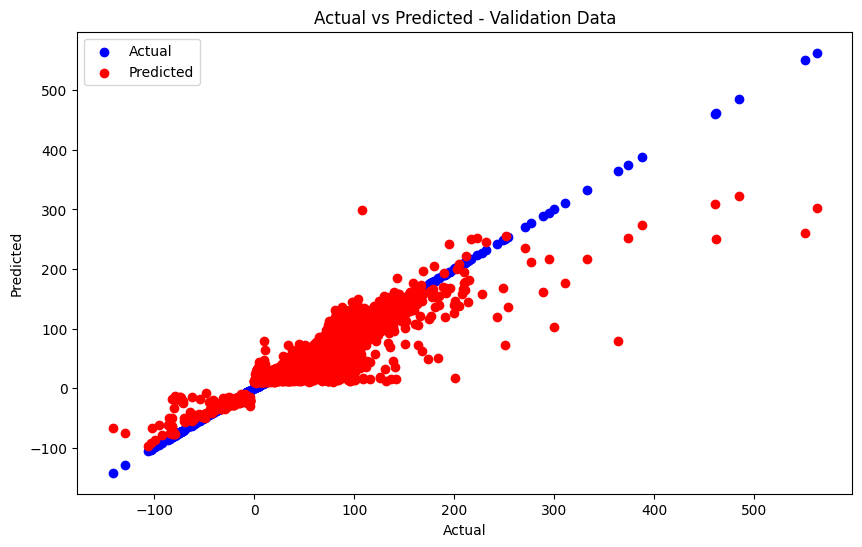

In [ ]:
predvsact(y_train,y_train_pred,y_val, y_val_pred)

The visual representation also shows some improvement over the previous model

## Random Forest Regressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=60, max_features=6, min_samples_leaf=50, random_state=42)
rfr.fit(X_train_prepared,y_train)


y_train_pred = rfr.predict(X_train_prepared)

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'Mean Squared Error (training): {mse}')
print(f'R2 Error (training): {r2}')

y_val_pred = rfr.predict(X_val_prepared)

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f'Mean Squared Error (val): {mse}')
print(f'R2 Error (val): {r2}')

# Cross validation score
print("CV Score:", cross_val_score(rfr,X_train_prepared, y_train, cv=5, scoring='r2'))

Mean Squared Error (training): 54.22769571269982
R2 Error (training): 0.915971953293661
Mean Squared Error (val): 54.24338948138959
R2 Error (val): 0.9166458547014548
CV Score: [0.89891796 0.91532086 0.92899945 0.91569976 0.88120559]


MSE and R2 Scores are better than the previous model

## Visualize Residual vs Predicted values

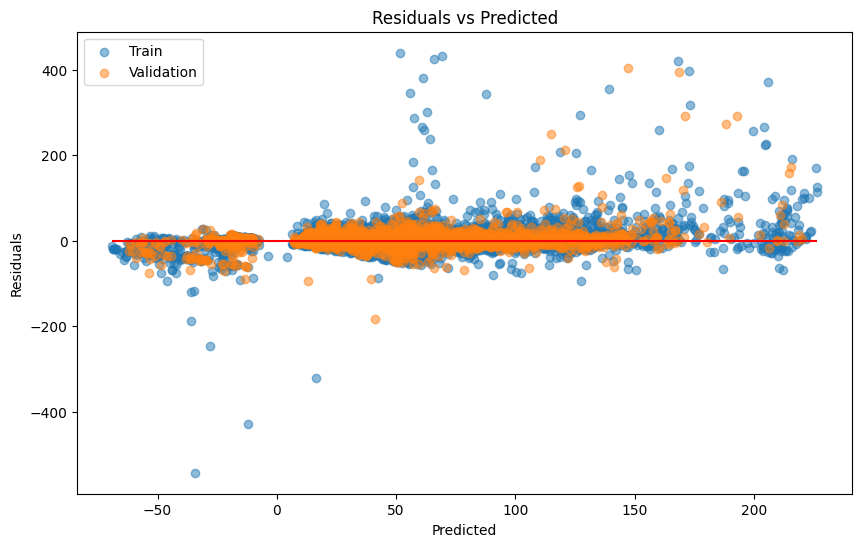

In [ ]:
resvspred(y_train,y_train_pred,y_val, y_val_pred)

The residuals are centered around 0 in a better way

## Visualize Actual vs Predicted values

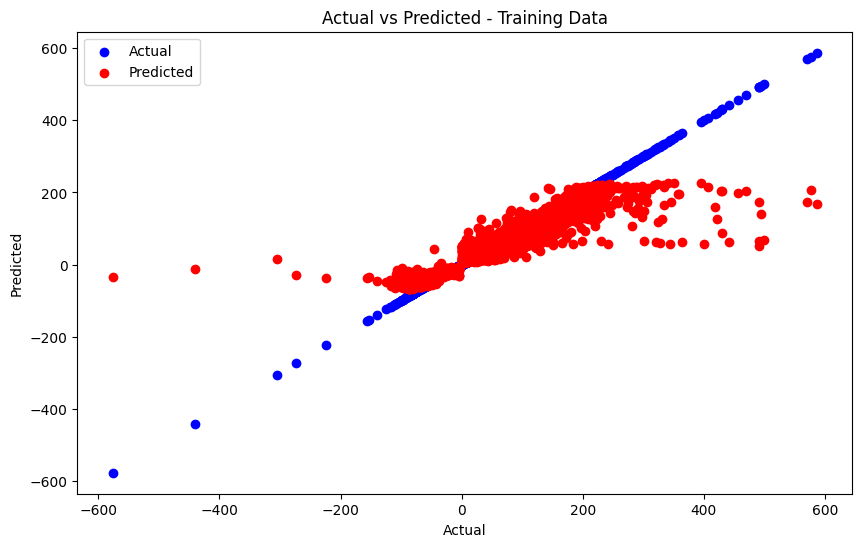

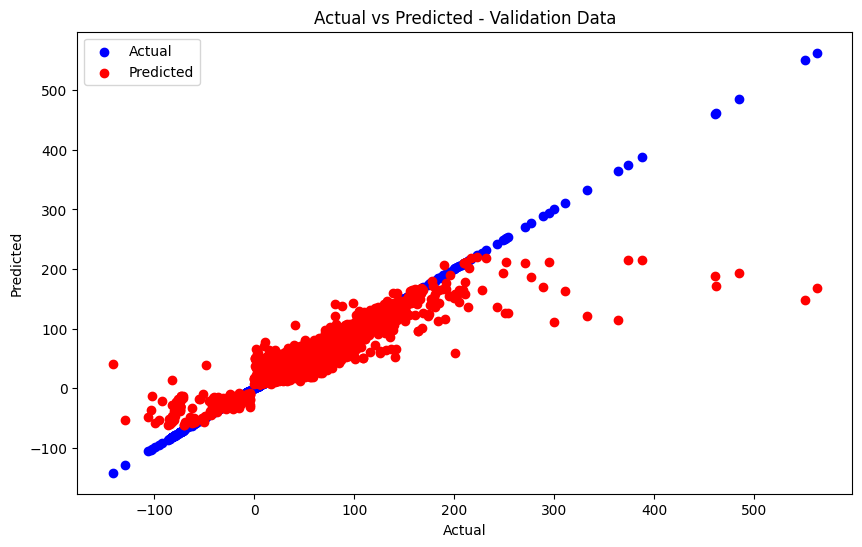

In [ ]:
predvsact(y_train,y_train_pred,y_val, y_val_pred)

Predictions are not more centerd around the actual values

## Hyperparamete tuning of Random forest Regressor

In [ ]:

'''
param_grid = [
    {'n_estimators': [10, 50, 100], 'max_features': [2, 4, 6, 8, 'log2', 'sqrt'], 'min_samples_leaf': [40,50,60,70]},
  ]


rfr = RandomForestRegressor(random_state=42)


grid_search_rfr = GridSearchCV(
    rfr,
    param_grid,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    cv=5,
)

grid_search_rfr.fit(X_train_prepared, y_train)

print(f"Best parameters: {grid_search.best_params_}")

y_train_pred = grid_search_rfr.predict(X_train_prepared)

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Error: {r2}')

y_val_pred = grid_search_rfr.predict(X_val_prepared)

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Error: {r2}')
'''

'\nparam_grid = [\n    {\'n_estimators\': [10, 50, 100], \'max_features\': [2, 4, 6, 8, \'log2\', \'sqrt\'], \'min_samples_leaf\': [40,50,60,70]},\n  ]\n\n\nrfr = RandomForestRegressor(random_state=42)\n\n\ngrid_search_rfr = GridSearchCV(\n    rfr, \n    param_grid,\n    scoring=\'neg_mean_squared_error\',\n    return_train_score=True,\n    cv=5,\n)\n\ngrid_search_rfr.fit(X_train_prepared, y_train)\n\nprint(f"Best parameters: {grid_search.best_params_}")\n\ny_train_pred = grid_search_rfr.predict(X_train_prepared)\n\nmse = mean_squared_error(y_train, y_train_pred)\nr2 = r2_score(y_train, y_train_pred)\n\nprint(f\'Mean Squared Error: {mse}\')\nprint(f\'R2 Error: {r2}\')\n\ny_val_pred = grid_search_rfr.predict(X_val_prepared)\n\nmse = mean_squared_error(y_val, y_val_pred)\nr2 = r2_score(y_val, y_val_pred)\n\nprint(f\'Mean Squared Error: {mse}\')\nprint(f\'R2 Error: {r2}\')\n'

## KNN Regressor

In [ ]:
knn = KNeighborsRegressor(n_neighbors = 8)
knn.fit(X_train_prepared, y_train)

y_train_pred = knn.predict(X_train_prepared)

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'Mean Squared Error (training): {mse}')
print(f'R2 Error (training): {r2}')

y_val_pred = knn.predict(X_val_prepared)

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f'Mean Squared Error (val): {mse}')
print(f'R2 Error (val): {r2}')

# Cross validation score
print("CV Score:", cross_val_score(knn,X_train_prepared, y_train, cv=5, scoring='r2'))

Mean Squared Error (training): 44.22929452949778
R2 Error (training): 0.9314648874958062
Mean Squared Error (val): 45.277458147946426
R2 Error (val): 0.930423525128208
CV Score: [0.91045685 0.91517994 0.91841997 0.90544478 0.89079965]


MSE and R2 shows imporvement over the previous models

## Visualize Residuals vs Predicted values

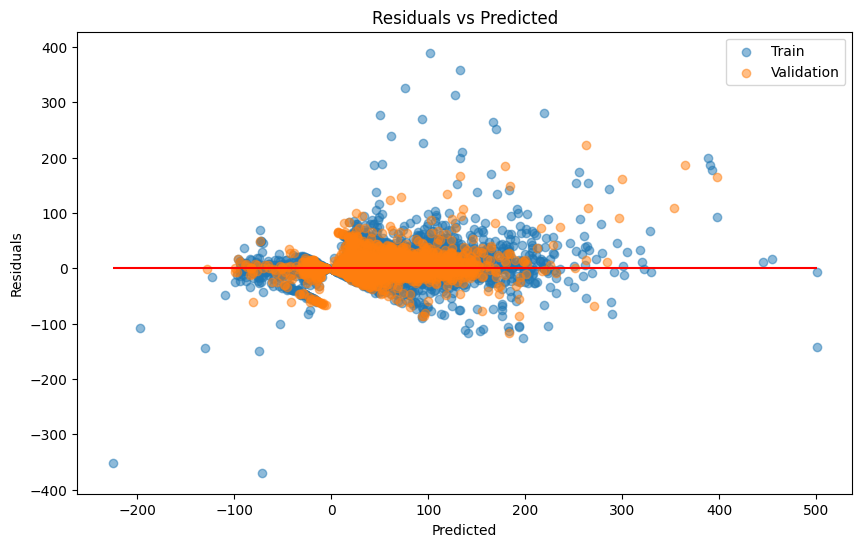

In [ ]:
resvspred(y_train,y_train_pred,y_val, y_val_pred)

The residuals are centered around 0

## Visualize Actual vs Predicted values

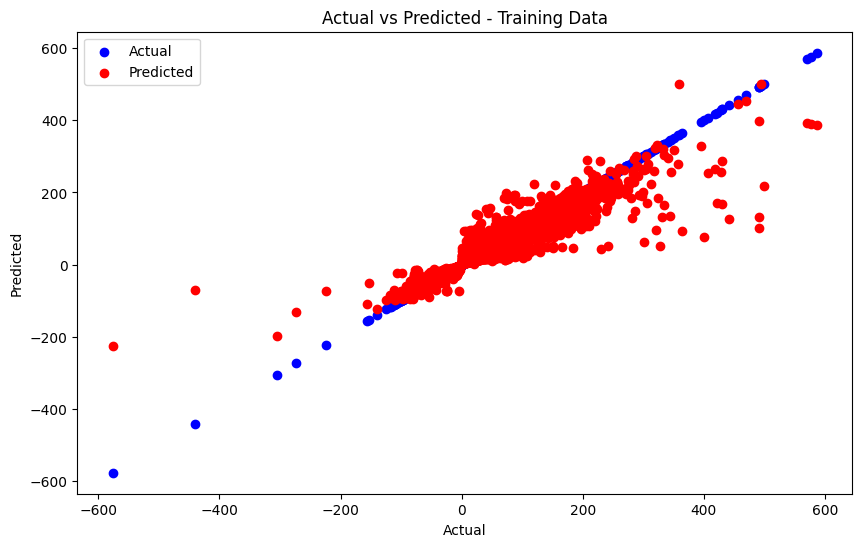

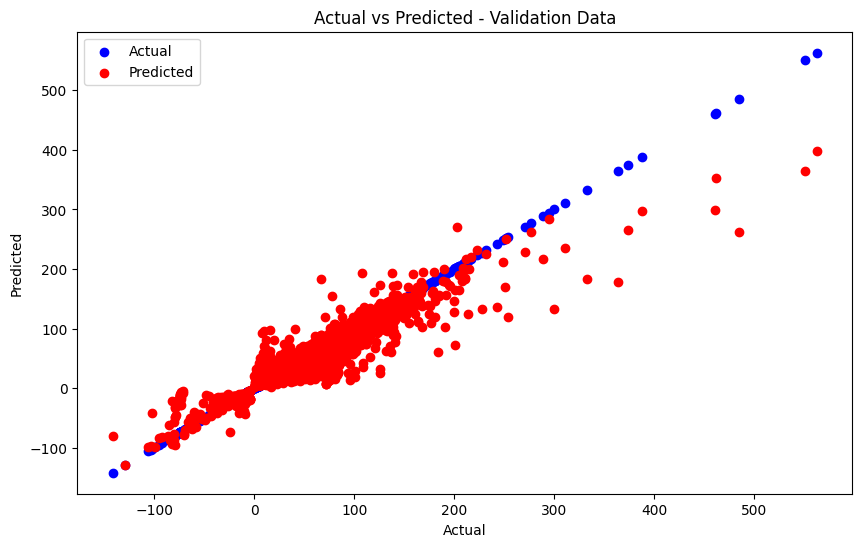

In [ ]:
predvsact(y_train,y_train_pred,y_val, y_val_pred)

The actual and the predicted values are overlaping in a much better way

## Hyperparameter Tuning of KNN Regressor

In [ ]:
'''
param_grid = {'n_neighbors': list(range(1, 21))}

knn = KNeighborsRegressor()

grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_knn.fit(X_train_prepared, y_train)

best_params = grid_search_knn.best_params_

y_train_pred = grid_search_knn.predict(X_train_prepared)

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Error: {r2}')

y_val_pred = grid_search_knn.predict(X_val_prepared)

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Error: {r2}') '''

'''
neighbors = list(range(1, 21))


errors = []


for k in neighbors:
     knn = KNeighborsRegressor(n_neighbors=k)
     knn.fit(X_train_prepared, y_train)
     y_val_pred = knn.predict(X_val_prepared)
     error = mean_squared_error(y_val, y_val_pred)
     errors.append(error)

plt.figure(figsize=(10, 6))
plt.plot(neighbors, errors, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Mean Squared Error')
plt.show()

'''


"\nneighbors = list(range(1, 21))\n \n \nerrors = []\n \n \nfor k in neighbors:\n     knn = KNeighborsRegressor(n_neighbors=k)\n     knn.fit(X_train_prepared, y_train)\n     y_val_pred = knn.predict(X_val_prepared)\n     error = mean_squared_error(y_val, y_val_pred)\n     errors.append(error)\n\nplt.figure(figsize=(10, 6))\nplt.plot(neighbors, errors, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)\nplt.title('Error Rate vs. K Value')\nplt.xlabel('K')\nplt.ylabel('Mean Squared Error')\nplt.show()\n\n"

# Run the model on test

## Check of test Data

In [ ]:
test.shape

(50000, 13)

In [ ]:
test.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,trip_duration
0,1,1.0,4.95,1.0,N,Credit Card,1.0,6.067612,0.0,1.0,2.5,0.0,4.000000
1,1,1.0,2.10,1.0,N,Credit Card,2.5,6.191269,0.0,1.0,2.5,0.0,8.500000
2,1,1.0,0.95,1.0,N,Cash,2.5,3.983872,0.0,1.0,2.5,0.0,66.733333
3,0,1.0,0.80,1.0,N,Credit Card,3.5,6.839341,0.0,1.0,2.5,0.0,12.450000
4,1,1.0,4.01,1.0,N,Cash,0.0,1.468943,0.0,1.0,0.0,0.0,28.383333


## Transform the data

In [ ]:
X_test_prepared = pipeline_transformer(test)

Data is passed through the same pipeline created earlier

In [ ]:
X_test_prepared.shape

(50000, 19)

## Make Prediction on test data using the best model

In [ ]:
y_pred_knn = knn.predict(X_test_prepared)

## Create csv file for the submission

In [ ]:
submission = pd.DataFrame({"ID": np.arange(1,50001),
                           "total_amount": y_pred_knn})

submission.to_csv('submission.csv',index=False)